# Predicción de Curvas Epidemiológicas de Covid-19 en México
**Un Enfoque Basado en Redes Neuronales y Aprenizaje Automático**


_Nombre Provisional_

* Estudiante: Lic. Eduardo Alán Hernandez Villasana
* Asesor de Tesis: Dr. Jose Daniel Mosquera Artamonov


## Librerias

In [1]:
import pandas as pd 
import os
import datetime as dt
import matplotlib.pyplot as plt
import time
import sys
import seaborn as sns
import progressbar
import warnings
import ast
from prophet import Prophet
import gc
warnings.filterwarnings('ignore')


c:\Users\alana\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Constants and Functions

### Constants

In [2]:
run_date = str(dt.date.today())
figures_path = "Graficas/"

### Funciones

In [3]:
def getDataFrame ():
    #url = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Datos%20Abiertos"
    url = "../../../../COVIDSTATSMX/Datos Abiertos"
    # Geting the file´s name YYMMDDCOVID19MEXICO.csv
    td = dt.date.today()
    date = '2022-07-22'
    sufix = "COVID19MEXICO.csv"
    covid_df = pd.read_csv(url+"/220722COVID19MEXICO.csv")

    return covid_df, date

In [4]:
# Print the cumulative cases
def printCumulativeCases (cCases, date, zone):
    # mortality rate
    mRate = cCases["Defunciones"] / cCases["Positivos"] * 100
    # positivity index
    pIndex = cCases["Positivos"] / (cCases["Negativos"] + cCases["Positivos"]) * 100

    print(
        f"Casos en {zone}\nFecha de actualización: {date} \n\n"
        f"  Total de casos estudiados: {cCases['Total']:,}\n\n"
        f"  Casos Positivos a SARS-CoV-2: {cCases['Positivos']:,}\n\n"
        f"  Casos No Positivos a SARS-CoV-2: {cCases['Negativos']:,}\n\n"
        f"  Casos Con Resultado Pendiente: {cCases['Pendientes']:,}\n\n"
        f"  Defunciones Positivas a SARS-CoV-2: {cCases['Defunciones']:,}\n\n"
        f"  Tasa de Letalidad: {mRate:.3f}%\n\n"
        f"  Tasa de Positividad : {pIndex:.3f}%\n"
    )

In [5]:
# Save on a dict the comulative cases
def getComulativeCases (covid_df):
    cases = covid_df[["RESULTADO","FECHA_DEF"]]
    grouped = covid_df.groupby("RESULTADO")["RESULTADO"].count()
    positiveC = grouped[1]
    negativeC = grouped[2]
    suspectedC = grouped[3]
    #suspectedC = len(cases[cases["RESULTADO"] == 3])
    deceased = len(cases[(cases["RESULTADO"] == 1) & (cases["FECHA_DEF"] != "9999-99-99")])
    dictCC = {
        "Positivos": positiveC,
        "Negativos": negativeC,
        "Pendientes": suspectedC,
        "Defunciones": deceased,
        "Total": len(cases)
    }
    return dictCC

In [6]:
# Get a list with dates YYYY-MM-DD
def getDateList (today_s):
    i = dt.date(2020,1,1) # Covid cases register starts on Junuary First 2020
    today_l = today_s.split('-')
    td = dt.date(int(today_l[0]),int(today_l[1]),int(today_l[2]))
    p_date = str(i.year)+"-"+"0"+str(i.month)+"-"+"0"+str(i.day)
    dates = [p_date]

    while i != td:
        i += dt.timedelta(days = 1)
        if (i.month < 10):
            month = "0"+str(i.month)
        else:
            month = str(i.month)
        
        if (i.day < 10):
            day = "0"+str(i.day)
        else:
            day = str(i.day)

        p_date = str(i.year) + "-" + month + "-" + day
        dates.append(p_date)
    return dates

In [7]:
def filter_by_zm (covid_df, zm_dict):
    df_codes = pd.DataFrame([(k, v) for k, values in zm_dict.items() for v in values], 
                  columns=["Estado", "Municipio"])
    # 'ENTIDAD_RES', 'MUNICIPIO_RES'
    df_codes["Estado"] = df_codes["Estado"].astype(int)
    df_codes["Municipio"] = df_codes["Municipio"].astype(int)
    df_filtered = covid_df.merge(df_codes, how = "inner",
                                 left_on = ['ENTIDAD_RES', 'MUNICIPIO_RES'],
                                 right_on = ["Estado", "Municipio"])
    
    df_filtered = df_filtered.drop(columns = ["Estado", "Municipio"])

    return df_filtered
    

In [8]:
# Filter the data and get a dict with the cases registraded by day
# There is an option where the state and county can be specified
def getCasesByDay (covid_df, dates, state = 0, countys = []):
    casesBD = {} # it will be changed to data frame

    covid_df = covid_df[["FECHA_SINTOMAS", "RESULTADO","FECHA_DEF", "HOSPITALIZADO"]][((covid_df["ENTIDAD_RES"] == state)
    |( state == 0)) 
    & ((covid_df["MUNICIPIO_RES"].isin (countys)) 
    | (len(countys) == 0))]

    casesBD ["FECHA"] = []
    casesBD ["CASOS_POSITIVOS"] = []
    casesBD ["CASOS_NEGATIVOS"] = []
    casesBD ["CASOS_SOSPECHOSOS"] = []
    casesBD ["DEFUNCIONES"] = []
    casesBD ["HOSPITALIZACIONES"] = []
    casesBD ["FECHA"] = dates
    #totalCases = len(covid_df)

    # Get Pandas series of cases using groupby
    positivesBD = covid_df[covid_df["RESULTADO"] == 1].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()
    negativesBD = covid_df[covid_df["RESULTADO"] == 2].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()
    suspectedsBD = covid_df[covid_df["RESULTADO"] == 3].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()
    deceasedsBD = covid_df[(covid_df["RESULTADO"] == 1) & (covid_df["FECHA_DEF"] != "9999-99-99") ].groupby(["FECHA_DEF","RESULTADO"])["RESULTADO"].count()
    hospitalizedBD = covid_df[(covid_df["HOSPITALIZADO"] == 1) & (covid_df["RESULTADO"] == 1)].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()

    # The data is filtered and positive cases, negative cases, suspicius cases and confirmed deaths for each day are count
    # For positive, negative and suspicious cases the column "FECHA" represents the day when the symptoms started,
    # while for deaths, it represent the date of death
    # It should not be forgotten that only cold numbers are shown here, but each one of the deaths represents a life lost.

    for date in casesBD["FECHA"]:

        try:
            pos = int(positivesBD[date])
        except:
            pos = 0
        
        try:
            neg = int(negativesBD[date])
        except:
            neg = 0
        
        try:
            sus = int(suspectedsBD[date])
        except:
            sus = 0
        
        try:
            dec = int(deceasedsBD[date])
        except:
            dec = 0

        try:
            hos = int(hospitalizedBD[date])
        except:
            hos = 0

        casesBD["CASOS_POSITIVOS"].append(pos)
        casesBD["CASOS_NEGATIVOS"].append(neg)
        casesBD["CASOS_SOSPECHOSOS"].append(sus)
        casesBD["DEFUNCIONES"].append(dec)
        casesBD["HOSPITALIZACIONES"].append(hos)
    return pd.DataFrame(casesBD)

In [9]:
def createGraph (name, casesBD_df, date):
    casesBD_df["FECHA"] = pd.to_datetime(casesBD_df["FECHA"], format = "%Y-%m-%d")
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["CASOS_POSITIVOS"], label = "Casos Positivos", color = "r", ax = ax)
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["DEFUNCIONES"], label = "Defunciones", color = "b", ax = ax)
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["CASOS_SOSPECHOSOS"], label = "Casos Sospechosos", color = "g", ax = ax)
    ax.set_title(f"GRAFICA {name} {date}")
    ax.set_ylabel("CASOS")
    plt.savefig(figures_path + name +" " + run_date + ".png")


def createGraph_ (name, casesBD_df, date):
    casesBD_df["FECHA"] = pd.to_datetime(casesBD_df["FECHA"], format = "%Y-%m-%d")
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["CASOS_POSITIVOS"], label = "Casos Positivos", color = "r", ax = ax)
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["DEFUNCIONES"], label = "Defunciones", color = "b", ax = ax)
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["CASOS_SOSPECHOSOS"], label = "Casos Sospechosos", color = "g", ax = ax)
    ax.set_title(f"GRAFICA {name} {date}")

In [10]:
def getResult (cl):
    positive = [1,2,3]
    negative = [7]
    #suspicious = 6

    if (cl in positive):
        return 1
    elif (cl in negative):
        return 2
    else:
        return 3

#### Prophet Functions

In [11]:
def prepare_data_for_prophet(df, date_col='date', value_col='value'):
    """
    Prepare DataFrame for Prophet by renaming columns and ensuring proper data types
    
    Parameters:
    df (DataFrame): Input DataFrame
    date_col (str): Name of the date column
    value_col (str): Name of the value column
    
    Returns:
    DataFrame: Prepared DataFrame for Prophet
    """
    prophet_df = df[[date_col, value_col]].copy()
    prophet_df.columns = ['ds', 'y']
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
    return prophet_df

In [12]:
def validate_data_for_prophet(df):
    """
    Validate DataFrame for Prophet requirements
    
    Parameters:
    df (DataFrame): Prophet-formatted DataFrame
    
    Returns:
    bool: True if data is valid, raises exception otherwise
    """
    # Check required columns
    if 'ds' not in df.columns or 'y' not in df.columns:
        raise ValueError("DataFrame must have 'ds' and 'y' columns")
    
    # Check for empty DataFrame
    if len(df) == 0:
        raise ValueError("DataFrame is empty")
    
    # Check for missing values
    if df['ds'].isnull().any():
        raise ValueError("Missing values found in 'ds' column")
    
    if df['y'].isnull().any():
        print(f"Warning: {df['y'].isnull().sum()} missing values found in 'y' column")
        print("Prophet can handle missing values, but consider imputing them if needed")
    
    # Check data types
    if not pd.api.types.is_datetime64_any_dtype(df['ds']):
        raise ValueError("'ds' column must be datetime type")
    
    if not pd.api.types.is_numeric_dtype(df['y']):
        raise ValueError("'y' column must be numeric type")
    
    # Check minimum data points
    if len(df) < 10:
        raise ValueError("Prophet requires at least 10 data points")
    
    print(f"Data validation passed: {len(df)} data points from {df['ds'].min()} to {df['ds'].max()}")
    return True

In [13]:
def fit_prophet_model(df, **prophet_params):
    """
    Fit Prophet model to the data
    
    Parameters:
    df (DataFrame): Prophet-formatted DataFrame
    **prophet_params: Additional parameters for Prophet model
    
    Returns:
    tuple: (fitted_model, forecast_dataframe, components_dataframe)
    """
    # Default Prophet parameters
    default_params = {
        'yearly_seasonality': True,
        'weekly_seasonality': True,
        'daily_seasonality': False,
        'seasonality_mode': 'additive',
        'changepoint_prior_scale': 0.05
    }

    # Update with user-provided parameters
    default_params.update(prophet_params)
    
    # Initialize and fit model
    model = Prophet(**default_params)
    print("Fitting Prophet model...")
    model.fit(df)
    
    # Create predictions for existing data
    components = model.predict(df)
    
    # Create future dataframe for forecasting
    future = model.make_future_dataframe(periods=90)
    forecast = model.predict(future)
    
    return model, forecast, components

In [33]:
def create_decomposition_dataframe(original_df, components_df):
    """
    Create DataFrame with decomposition components
    
    Parameters:
    original_df (DataFrame): Original Prophet-formatted data
    components_df (DataFrame): Prophet components predictions
    
    Returns:
    DataFrame: Decomposition results
    """
    decomposition = pd.DataFrame({
        'date': original_df['ds'],
        'original': original_df['y'],
        'trend': components_df['trend'],
        'yearly_seasonal': components_df['yearly'],
        'weekly_seasonal': components_df['weekly'],
        'holidays': components_df['holidays'],
        'residual': original_df['y'] - components_df['yhat']
    })
    return decomposition

In [37]:
def plot_decomposition(decomposition_df, name, figsize=(12, 15)):
    """
    Plot time series decomposition components
    
    Parameters:
    decomposition_df (DataFrame): Decomposition results DataFrame
    name: Name of the fig
    figsize (tuple): Figure size (width, height)
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    fig, axes = plt.subplots(6, 1, figsize=figsize)
    main_title = f'Descomposición de Serie de Tiempo\n{name}\n{run_date}'
    fig.suptitle(main_title, fontsize=16, fontweight='bold', y = 0.99)

    # Define plot configurations
    plot_configs = [
        {'data': 'original', 'title': 'Serie de Tiempo Original', 'color': 'black'},
        {'data': 'trend', 'title': 'Tendencia', 'color': 'blue'},
        {'data': 'yearly_seasonal', 'title': 'Componente Estacional Anual', 'color': 'green'},
        {'data': 'weekly_seasonal', 'title': 'Componente Estacional Semanal', 'color': 'orange'},
        {'data': 'residual', 'title': 'Residuo', 'color': 'red'},
        {'data': 'holidays', 'title': 'Dias Festivos', 'color': 'violet'}
    ]
    
    for i, config in enumerate(plot_configs):
        axes[i].plot(decomposition_df['date'], decomposition_df[config['data']], 
                    color=config['color'], linewidth=1 if i != 1 else 2)
        axes[i].set_title(config['title'])
        axes[i].set_ylabel(config['title'].split()[0])
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Fecha')
    plt.tight_layout()
    plt.savefig(f'{figures_path}Descomposición de Serie de Tiempo-{name}-{run_date}.png')
    return fig

#### Extra Functions

In [16]:
def plot_component_contributions(decomposition_df, figsize=(10, 6)):
    """
    Plot the contribution of each component to total variance
    
    Parameters:
    decomposition_df (DataFrame): Decomposition results DataFrame
    figsize (tuple): Figure size (width, height)
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    # Calculate contributions
    total_variation = decomposition_df['original'].var()
    contributions = {
        'Trend': decomposition_df['trend'].var() / total_variation * 100,
        'Yearly Seasonal': decomposition_df['yearly_seasonal'].var() / total_variation * 100,
        'Weekly Seasonal': decomposition_df['weekly_seasonal'].var() / total_variation * 100,
        'Residual': decomposition_df['residual'].var() / total_variation * 100
    }
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=figsize)
    components = list(contributions.keys())
    values = list(contributions.values())
    colors = ['blue', 'green', 'orange', 'red']
    
    bars = ax.bar(components, values, color=colors, alpha=0.7)
    ax.set_title('Component Contribution to Total Variance')
    ax.set_ylabel('Contribution (%)')
    ax.set_xlabel('Components')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.1f}%', ha='center', va='bottom')
    
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    return fig

In [39]:
def print_decomposition_summary(decomposition_df):
    """
    Print summary statistics of the decomposition
    
    Parameters:
    decomposition_df (DataFrame): Decomposition results DataFrame
    """
    print("\nTime Series Decomposition Summary:")
    print("=" * 40)
    print(f"Data points: {len(decomposition_df)}")
    print(f"Date range: {decomposition_df['date'].min()} to {decomposition_df['date'].max()}")
    
    print("\nComponent Statistics:")
    print(f"Trend range: {decomposition_df['trend'].min():.2f} to {decomposition_df['trend'].max():.2f}")
    print(f"Yearly seasonal range: {decomposition_df['yearly_seasonal'].min():.2f} to {decomposition_df['yearly_seasonal'].max():.2f}")
    print(f"Weekly seasonal range: {decomposition_df['weekly_seasonal'].min():.2f} to {decomposition_df['weekly_seasonal'].max():.2f}")
    print(f"Holiday impact range: {decomposition_df['holidays'].min():.2f} to {decomposition_df['holidays'].max():.2f}")
    print(f"Residual std: {decomposition_df['residual'].std():.2f}")

In [40]:
def print_component_analysis(decomposition_df):
    """
    Print detailed component contribution analysis
    
    Parameters:
    decomposition_df (DataFrame): Decomposition results DataFrame
    """
    print("\nComponent Contribution Analysis:")
    print("=" * 40)
    total_variation = decomposition_df['original'].var()
    
    contributions = {
        'Trend': decomposition_df['trend'].var() / total_variation * 100,
        'Yearly seasonal': decomposition_df['yearly_seasonal'].var() / total_variation * 100,
        'Weekly seasonal': decomposition_df['weekly_seasonal'].var() / total_variation * 100,
        'Holidays': decomposition_df['holidays'].var() / total_variation * 100,
        'Residual': decomposition_df['residual'].var() / total_variation * 100
    }
    
    for component, contribution in contributions.items():
        print(f"{component} contribution to variance: {contribution:.1f}%")

## Extracción de Datos

In [19]:
# Se cargan los diccionarios por zonas metropolitanas
df_ZM = pd.read_excel("Diccionario Municipios.xlsx").fillna("")

In [20]:
# Getting the data and preparing it
covid_df, update_date = getDataFrame()
dates = getDateList(update_date)
covid_df["RESULTADO"] = covid_df["CLASIFICACION_FINAL"].apply(getResult)
covid_df["HOSPITALIZADO"] = covid_df["TIPO_PACIENTE"].apply(lambda x: 1 if x == 2 else 0)

In [52]:
holidays_mx = pd.read_csv("holidays_mexico_2020_2022.csv")

## Analisis por Áreas:

* Escenario Nacional
* Zona Metropolitana de la Ciudad de México.
* Zona Metropolitana de Monterrey
* Zona Metropolitana de Guadalajara
* Ciudad Victoria   

In [24]:
# Filtrado y preparación del dataset con los codigos de as zonas metropolitanas
df_ZM = df_ZM[df_ZM["Codigos de Dataset"] != ""]
df_ZM["Codigos de Dataset"] = df_ZM["Codigos de Dataset"].apply(ast.literal_eval)

### Análisis de Escenario Nacional

#### Eacenario Nacional

In [25]:
nacional_cc = getComulativeCases(covid_df)
printCumulativeCases(nacional_cc, update_date, "México")

Casos en México
Fecha de actualización: 2022-07-22 

  Total de casos estudiados: 17,410,397

  Casos Positivos a SARS-CoV-2: 6,588,854

  Casos No Positivos a SARS-CoV-2: 10,075,536

  Casos Con Resultado Pendiente: 746,007

  Defunciones Positivas a SARS-CoV-2: 326,968

  Tasa de Letalidad: 4.962%

  Tasa de Positividad : 39.539%



In [26]:
casesBD_df = getCasesByDay(covid_df, dates)

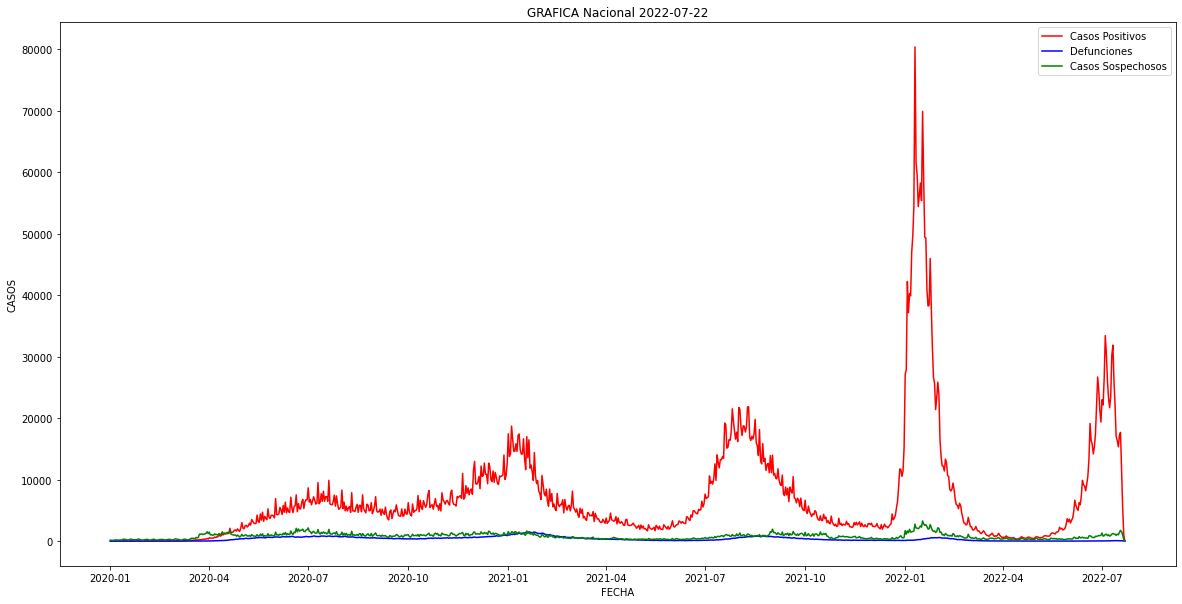

In [ ]:
createGraph("Nacional", casesBD_df, update_date)

#### Descomposición de Serie de tiempo

In [53]:
prophet_national_df = prepare_data_for_prophet(casesBD_df, 'FECHA', 'CASOS_POSITIVOS')
model, forecast, components = fit_prophet_model(prophet_national_df, holidays = holidays_mx)
decomposition = create_decomposition_dataframe(prophet_national_df, components)

Fitting Prophet model...


20:57:28 - cmdstanpy - INFO - Chain [1] start processing
20:57:28 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
print("Descomposición en Componentes de Serie de Tiempo\nEscenario Nacional")
print_decomposition_summary(decomposition)
print_component_analysis(decomposition)

Descomposición en Componentes de Serie de Tiempo
Escenario Nacional

Time Series Decomposition Summary:
Data points: 934
Date range: 2020-01-01 00:00:00 to 2022-07-22 00:00:00

Component Statistics:
Trend range: -5736.91 to 12176.92
Yearly seasonal range: -6640.19 to 10910.44
Weekly seasonal range: -545.96 to 1378.97
Holiday impact range: -12303.86 to 35128.90
Residual std: 5318.09

Component Contribution Analysis:
Trend contribution to variance: 14.4%
Yearly seasonal contribution to variance: 30.0%
Weekly seasonal contribution to variance: 0.5%
Holidays contribution to variance: 16.9%
Residual contribution to variance: 33.9%


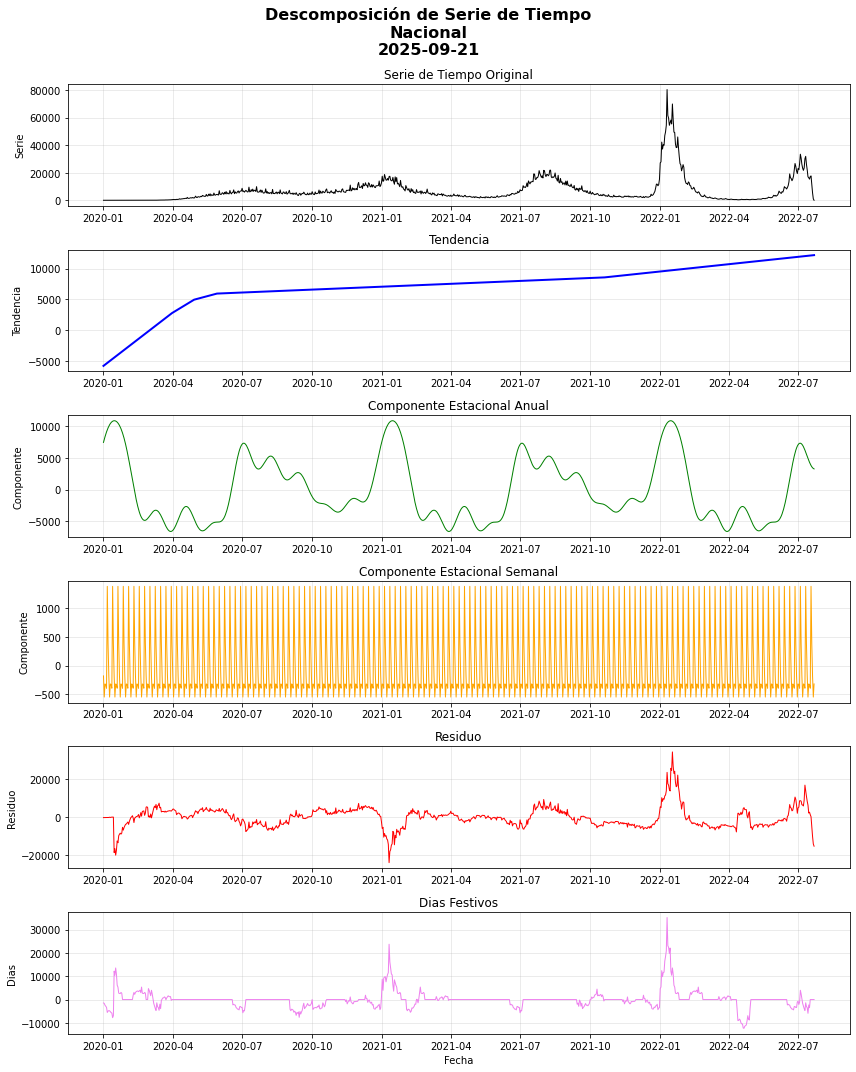

In [55]:
fig1 = plot_decomposition(decomposition, f"Nacional")

### Análisis de la Zona Metropolitana de la Ciudad de México


#### Escenario en la Zona Metropolitana de la Ciudad de México

In [56]:
cdmx_code = df_ZM[df_ZM["Nombre"] == "Zona metropolitana de Ciudad de México"]["Codigos de Dataset"].iloc[0]
# La ZMCDMX contiene municipios de diferentes estados.
cdmx_df = filter_by_zm(covid_df, cdmx_code)

In [57]:
cdmx_df.shape

(7027643, 42)

In [58]:
cdmx_cc = getComulativeCases(cdmx_df)
printCumulativeCases(cdmx_cc, update_date, "ZM de la Ciudad de México")

Casos en ZM de la Ciudad de México
Fecha de actualización: 2022-07-22 

  Total de casos estudiados: 7,027,643

  Casos Positivos a SARS-CoV-2: 2,181,223

  Casos No Positivos a SARS-CoV-2: 4,610,607

  Casos Con Resultado Pendiente: 235,813

  Defunciones Positivas a SARS-CoV-2: 81,632

  Tasa de Letalidad: 3.742%

  Tasa de Positividad : 32.115%



In [59]:
cases_cdmx_df = getCasesByDay(cdmx_df, dates)

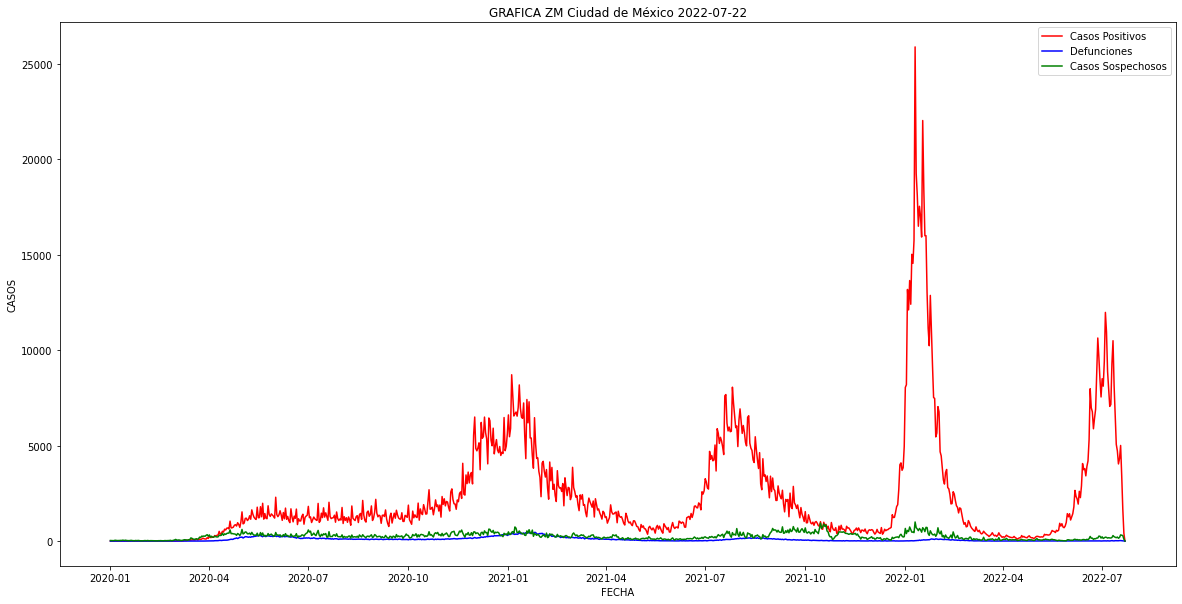

In [60]:
createGraph("ZM Ciudad de México", cases_cdmx_df, update_date)

#### Descomposición de Serie de tiempo

In [62]:
prophet_cdmx_df = prepare_data_for_prophet(cases_cdmx_df, 'FECHA', 'CASOS_POSITIVOS')
model, forecast, components = fit_prophet_model(prophet_cdmx_df,  holidays = holidays_mx)
decomposition = create_decomposition_dataframe(prophet_cdmx_df, components)

Fitting Prophet model...


20:59:39 - cmdstanpy - INFO - Chain [1] start processing
20:59:39 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
print("Descomposición en Componentes de Serie de Tiempo\nZona Metropolitana de la Ciudad de México")
print_decomposition_summary(decomposition)
print_component_analysis(decomposition)

Descomposición en Componentes de Serie de Tiempo
Zona Metropolitana de la Ciudad de México

Time Series Decomposition Summary:
Data points: 934
Date range: 2020-01-01 00:00:00 to 2022-07-22 00:00:00

Component Statistics:
Trend range: -2368.40 to 4049.02
Yearly seasonal range: -2105.90 to 4400.29
Weekly seasonal range: -347.68 to 490.02
Holiday impact range: -3697.02 to 10984.42
Residual std: 1708.71

Component Contribution Analysis:
Trend contribution to variance: 16.2%
Yearly seasonal contribution to variance: 34.5%
Weekly seasonal contribution to variance: 0.7%
Holidays contribution to variance: 15.5%
Residual contribution to variance: 32.2%


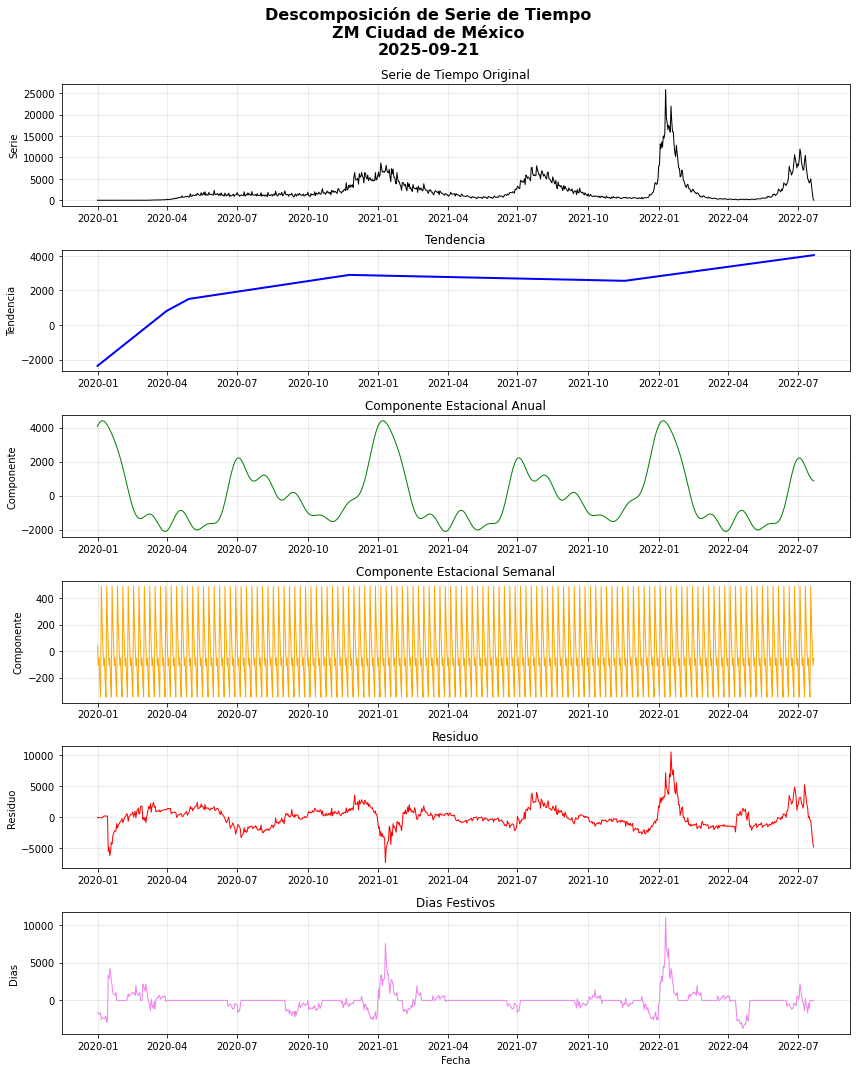

In [64]:
fig1 = plot_decomposition(decomposition, f"ZM Ciudad de México")

### Análisis de la Zona Metropolitana de Monterrey

#### Escenario en la Zona Metropolitana de Monterrey

In [65]:
mty_codes = df_ZM[df_ZM["Nombre"] == "Zona metropolitana de Monterrey"]["Codigos de Dataset"].iloc[0]
mty_df = filter_by_zm(covid_df, mty_codes)

In [66]:
mty_df.shape

(705152, 42)

In [67]:
mty_cc = getComulativeCases(mty_df)
printCumulativeCases(mty_cc, update_date, "ZM de Monterrey")

Casos en ZM de Monterrey
Fecha de actualización: 2022-07-22 

  Total de casos estudiados: 705,152

  Casos Positivos a SARS-CoV-2: 336,991

  Casos No Positivos a SARS-CoV-2: 348,123

  Casos Con Resultado Pendiente: 20,038

  Defunciones Positivas a SARS-CoV-2: 14,160

  Tasa de Letalidad: 4.202%

  Tasa de Positividad : 49.188%



In [68]:
cases_mty_df = getCasesByDay(mty_df, dates)

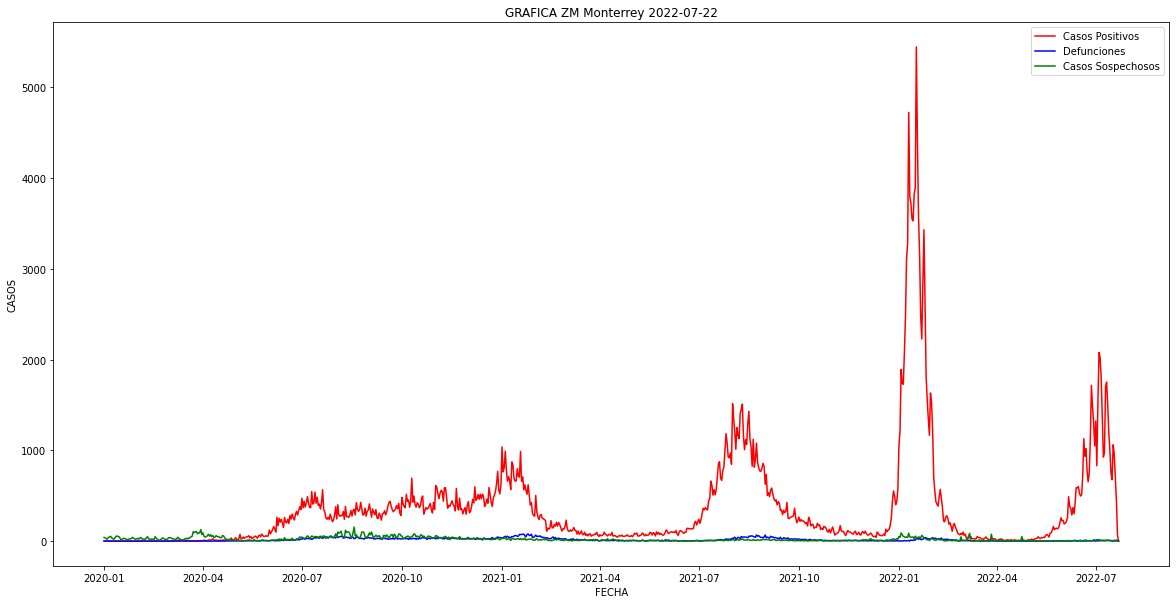

In [ ]:
createGraph("ZM Monterrey", cases_mty_df, update_date)

#### Descomposición de Serie de tiempo

In [69]:
prophet_df = prepare_data_for_prophet(cases_mty_df, 'FECHA', 'CASOS_POSITIVOS')
model, forecast, components = fit_prophet_model(prophet_df,  holidays = holidays_mx)
decomposition = create_decomposition_dataframe(prophet_df, components)

Fitting Prophet model...


21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:43 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
print_decomposition_summary(decomposition)
print_component_analysis(decomposition)


Time Series Decomposition Summary:
Data points: 934
Date range: 2020-01-01 00:00:00 to 2022-07-22 00:00:00

Component Statistics:
Trend range: -294.95 to 761.63
Yearly seasonal range: -419.57 to 667.33
Weekly seasonal range: -41.19 to 89.86
Holiday impact range: -678.55 to 2038.01
Residual std: 361.18

Component Contribution Analysis:
Trend contribution to variance: 11.6%
Yearly seasonal contribution to variance: 28.7%
Weekly seasonal contribution to variance: 0.6%
Holidays contribution to variance: 17.1%
Residual contribution to variance: 38.6%


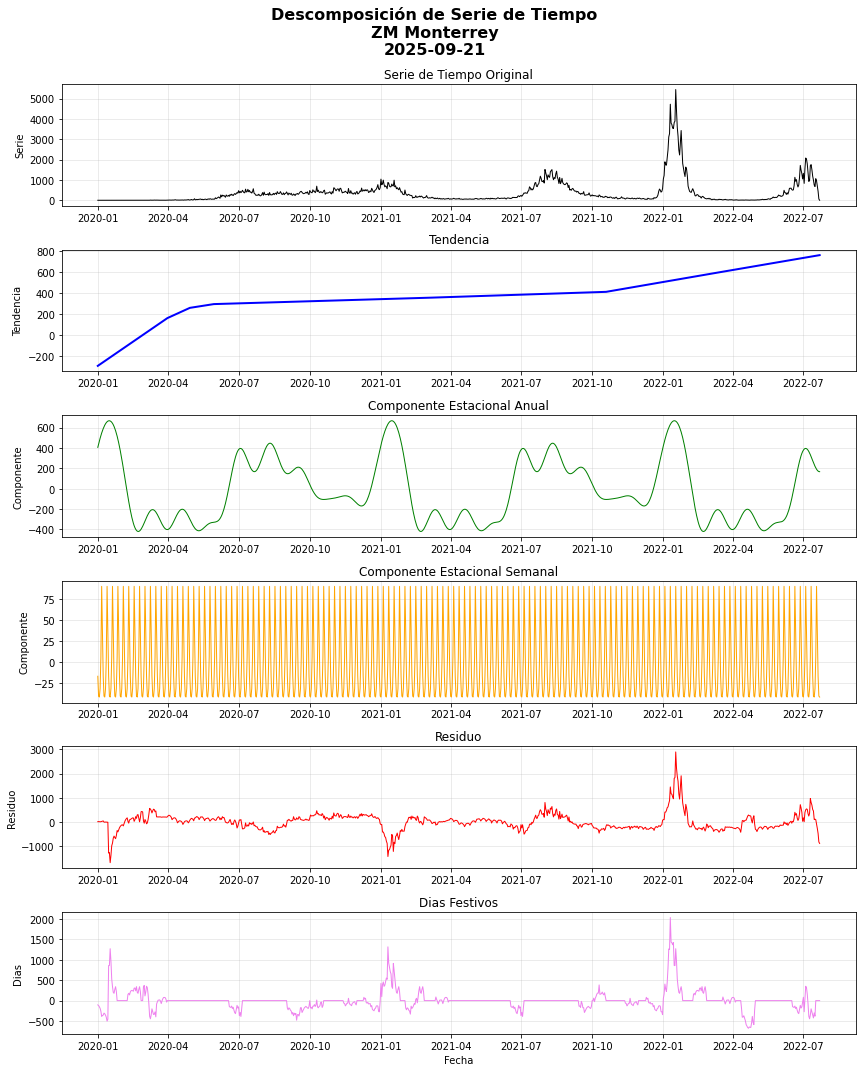

In [71]:
fig1 = plot_decomposition(decomposition, f"ZM Monterrey")

### Análisis de la Zona Metropolitana de Guadajalara

#### Escenario en la Zona Metropolitana de Guadalajara

In [72]:
gdl_codes = df_ZM[df_ZM["Nombre"] == "Zona metropolitana de Guadalajara"]["Codigos de Dataset"].iloc[0]
gdl_df = filter_by_zm(covid_df, gdl_codes)

In [73]:
gdl_df.shape

(406398, 42)

In [79]:
gdl_cc = getComulativeCases(gdl_df)
printCumulativeCases(gdl_cc, update_date, "ZM de Guadalajara")

Casos en ZM de Guadalajara
Fecha de actualización: 2022-07-22 

  Total de casos estudiados: 406,398

  Casos Positivos a SARS-CoV-2: 190,493

  Casos No Positivos a SARS-CoV-2: 194,295

  Casos Con Resultado Pendiente: 21,610

  Defunciones Positivas a SARS-CoV-2: 13,233

  Tasa de Letalidad: 6.947%

  Tasa de Positividad : 49.506%



In [75]:
cases_gdl_df = getCasesByDay(gdl_df, dates)

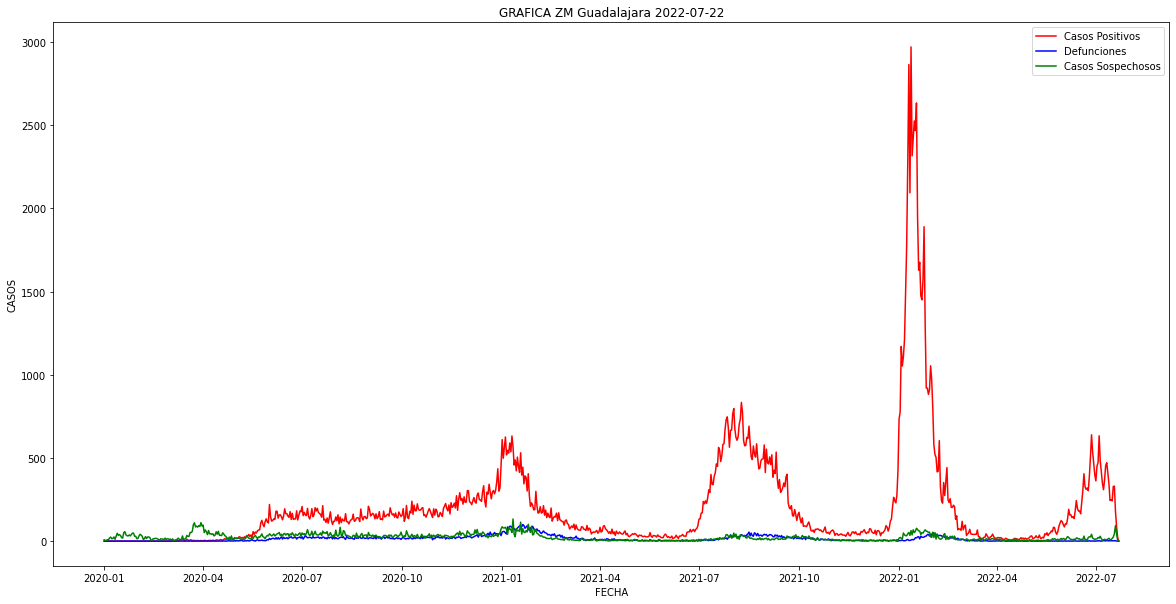

In [ ]:
createGraph("ZM Guadalajara", cases_gdl_df, update_date)

#### Descomposición de Serie de tiempo

In [76]:
prophet_df = prepare_data_for_prophet(cases_gdl_df, 'FECHA', 'CASOS_POSITIVOS')
model, forecast, components = fit_prophet_model(prophet_df,  holidays = holidays_mx)
decomposition = create_decomposition_dataframe(prophet_df, components)

Fitting Prophet model...


21:01:34 - cmdstanpy - INFO - Chain [1] start processing
21:01:35 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
print_decomposition_summary(decomposition)
print_component_analysis(decomposition)


Time Series Decomposition Summary:
Data points: 934
Date range: 2020-01-01 00:00:00 to 2022-07-22 00:00:00

Component Statistics:
Trend range: -285.05 to 337.22
Yearly seasonal range: -237.14 to 487.33
Weekly seasonal range: -23.67 to 47.09
Holiday impact range: -415.55 to 1293.60
Residual std: 192.24

Component Contribution Analysis:
Trend contribution to variance: 13.2%
Yearly seasonal contribution to variance: 32.3%
Weekly seasonal contribution to variance: 0.4%
Holidays contribution to variance: 18.7%
Residual contribution to variance: 33.2%


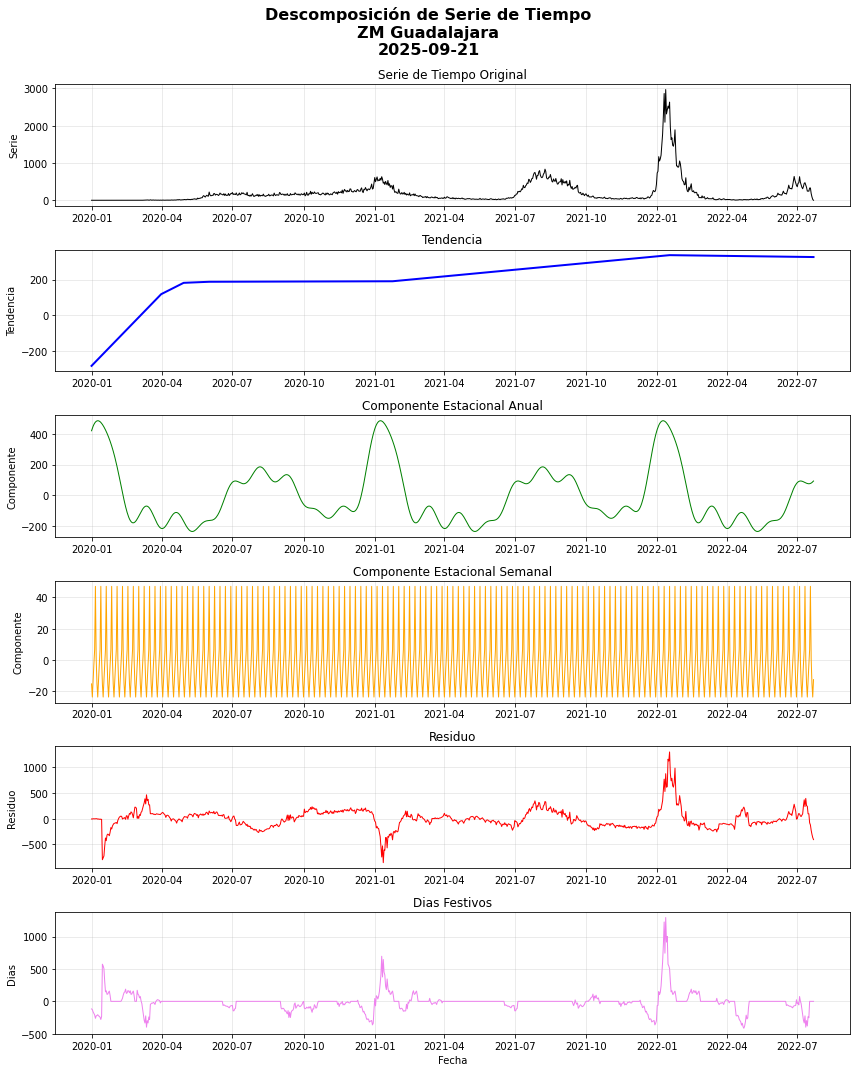

In [78]:
fig1 = plot_decomposition(decomposition, f"ZM Guadalajara")

### Análisis de Ciudad Victoria

#### Escenario en Ciudad Victoria

In [86]:
cdv_codes = df_ZM[df_ZM["Nombre"] == "Ciudad Victoria"]["Codigos de Dataset"].iloc[0]
cdv_df = filter_by_zm(covid_df, cdv_codes)

In [87]:
cdv_df.shape

(59082, 42)

In [88]:
cdv_cc = getComulativeCases(cdv_df)
printCumulativeCases(cdv_cc, update_date, "Ciudad Victoria")

Casos en Ciudad Victoria
Fecha de actualización: 2022-07-22 

  Total de casos estudiados: 59,082

  Casos Positivos a SARS-CoV-2: 20,841

  Casos No Positivos a SARS-CoV-2: 36,174

  Casos Con Resultado Pendiente: 2,067

  Defunciones Positivas a SARS-CoV-2: 648

  Tasa de Letalidad: 3.109%

  Tasa de Positividad : 36.554%



In [89]:
cases_cdv_df = getCasesByDay(cdv_df, dates)

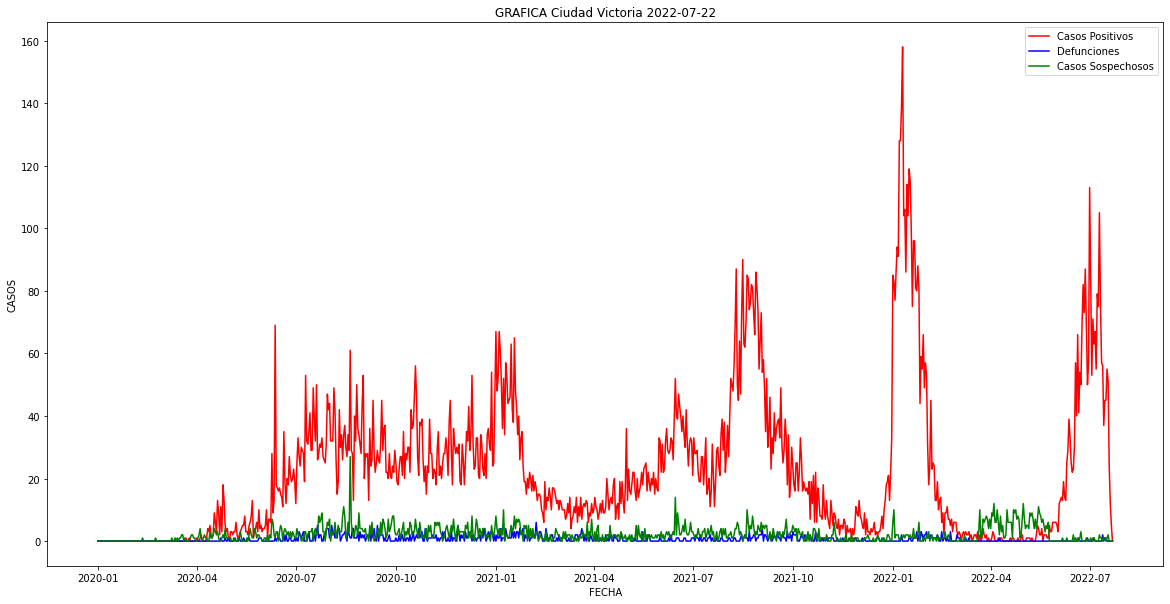

In [90]:
createGraph("Ciudad Victoria", cases_cdv_df, update_date)

#### Descomposición de Serie de tiempo

In [91]:
prophet_df = prepare_data_for_prophet(cases_cdv_df, 'FECHA', 'CASOS_POSITIVOS')
model, forecast, components = fit_prophet_model(prophet_df,  holidays = holidays_mx)
decomposition = create_decomposition_dataframe(prophet_df, components)

Fitting Prophet model...


21:17:30 - cmdstanpy - INFO - Chain [1] start processing
21:17:30 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
print_decomposition_summary(decomposition)
print_component_analysis(decomposition)


Time Series Decomposition Summary:
Data points: 934
Date range: 2020-01-01 00:00:00 to 2022-07-22 00:00:00

Component Statistics:
Trend range: -1.02 to 27.75
Yearly seasonal range: -20.25 to 32.81
Weekly seasonal range: -2.09 to 2.85
Holiday impact range: -33.53 to 74.49
Residual std: 13.00

Component Contribution Analysis:
Trend contribution to variance: 10.0%
Yearly seasonal contribution to variance: 34.5%
Weekly seasonal contribution to variance: 0.4%
Holidays contribution to variance: 20.8%
Residual contribution to variance: 30.9%


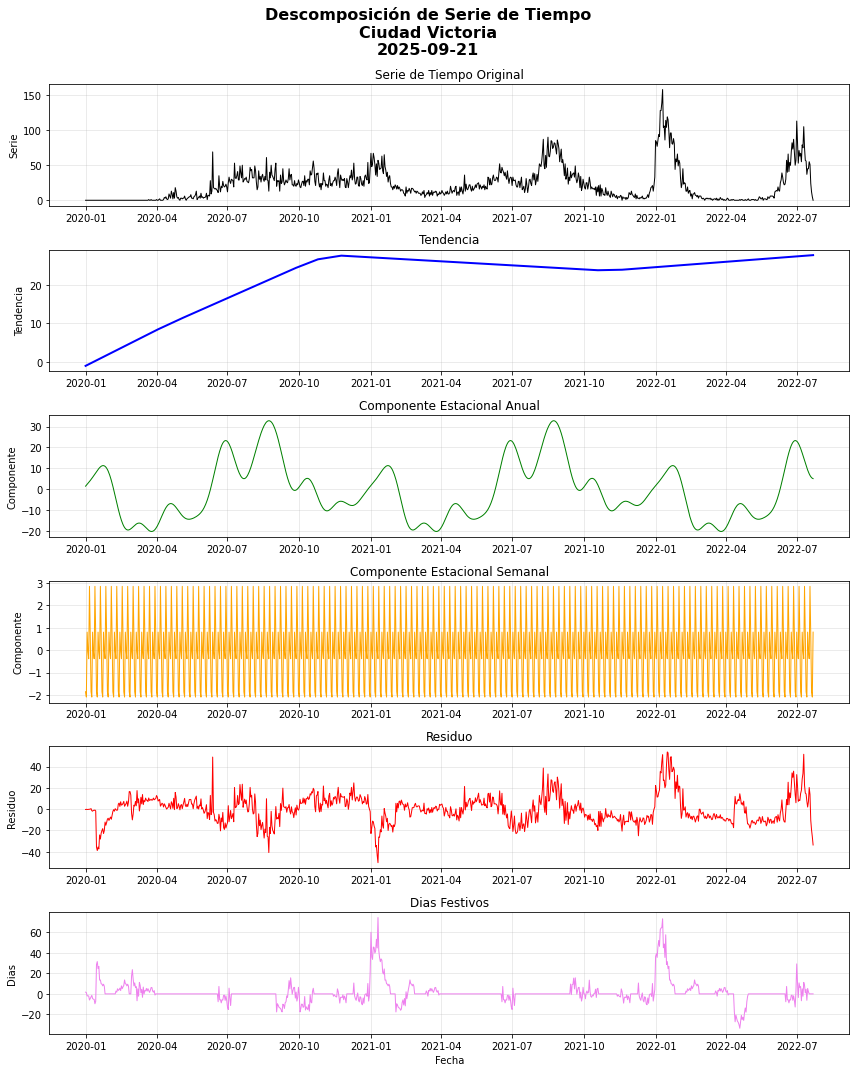

In [93]:
fig1 = plot_decomposition(decomposition, f"Ciudad Victoria")